In [1]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.4 MB/s eta 0:00:00


#Connecting to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/My Drive/emnist"

Mounted at /content/drive/
/content/drive/My Drive/emnist


#Imporitng library

In [40]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import time
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential,load_model
from keras.callbacks import LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import keras_tuner as kt
from google.colab import drive
import matplotlib.pyplot as plt

#Dataset pre-processing

In [4]:
#importing dataset
train = pd.read_csv("emnist-balanced-train.csv", header = None)
test = pd.read_csv("emnist-balanced-test.csv", header = None)
mapping = pd.read_csv("emnist-balanced-mapping.txt", sep = " ", header = None)

In [5]:
#printing training and testing dataset size before pre-precessing
print("Training size:", train.shape)
print("Testing size:", test.shape)

Training size: (112800, 785)
Testing size: (18800, 785)


In [6]:
#function to rotate and flip images so as to make to readable to apt for training
def imageProcess(im):
  im = np.fliplr(np.rot90(im.reshape(28,28), k=3))

  return im

#processing dataset so as to convert it to numpy images and one hot encode labels
def datasetPP(dataset):
  no_class = 47

  y_dataset = tf.keras.utils.to_categorical(dataset[0].to_numpy().astype('float32'), no_class) 
  x = dataset.loc[:, train.columns != 0].to_numpy().astype('float32')

  x_dataset = np.array(list(map(imageProcess, x)))
  x_dataset = x_dataset.reshape(x_dataset.shape[0], 28, 28, 1)

  return x_dataset, y_dataset

#mapping labels to correct ascii value
l = list(mapping[1])
label = {}
j=0
for i in l:
  label[j] = chr(i)
  j+=1

#obtain processed dataset
x_train, y_train = datasetPP(train)
x_test, y_test = datasetPP(test)

#Understanding the dataset

In [38]:
#print newly processed train and test dataset shapes
print("x_train size/shape:",x_train.shape)
print("y_train size/shape:",y_train.shape)
print("\n")
print("x_test size/shape:",x_test.shape)
print("y_test size/shape:",y_test.shape)

x_train size/shape: (112800, 28, 28, 1)
y_train size/shape: (112800, 47)


x_test size/shape: (18800, 28, 28, 1)
y_test size/shape: (18800, 47)


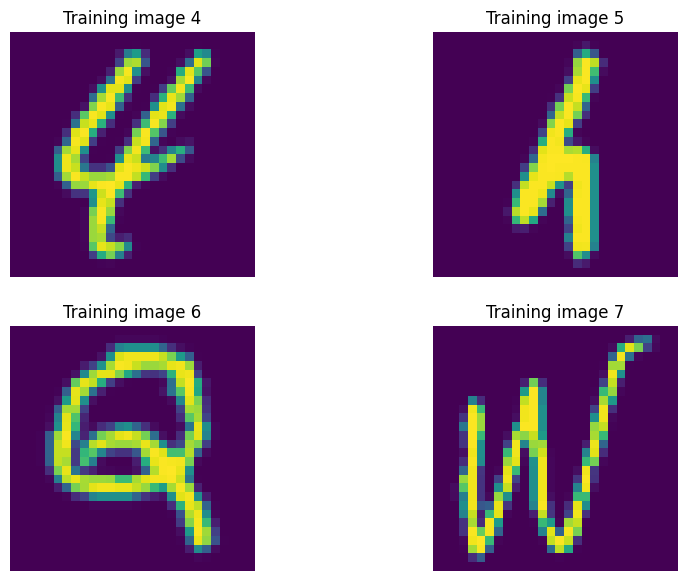

In [39]:
#print sample images from training dataset to understand what we're working with

fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(x_train[4])
plt.axis('off')
plt.title("Training image 4")

fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(x_train[5])
plt.axis('off')
plt.title("Training image 5")

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(x_train[6])
plt.axis('off')
plt.title("Training image 6")

fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(x_train[7])
plt.axis('off')
plt.title("Training image 7")

plt.show()

#Neural network class for tuning and testing

In [10]:
from kerastuner import HyperModel

#designing a class for neural networks

class nn(HyperModel):

  def __init__(self, x, y):
    #dataset for training
    self.x = x
    self.y = y

  #function to tune hyperparameter for mlp
  def build_mlp(self, hp):
    hp_activation = hp.Choice('activation_function', values=['relu', 'tanh', 'elu']) #activation function to optimize
    hp_adaptive = hp.Choice('learning_rate_scheduler', values = ['time', 'step']) #learning rate scheduler to optimize
    hp_optimizer = hp.Choice('optimizer', values = ['adam', 'rmsprop', 'adagrad']) #optimizer to optimizer
    hp_regularizer = hp.Choice('regularizer', values = ['l1', 'l2', 'l1_l2']) #regularizer to optimize
    hp_drop = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05) #dropout rate to optimize

    model = self.mlp(activation = hp_activation, optimizer = hp_optimizer, regularizer = hp_regularizer, drop = hp_drop)

    return model

  #function to tune hyperparemeter for cnn
  def build_cnn(self, hp):
    hp_activation = hp.Choice('activation_function', values=['relu', 'tanh', 'elu']) #activation function to optimize
    hp_adaptive = hp.Choice('learning_rate_scheduler', values = ['time', 'step']) #learning rate scheduler to optimize
    hp_optimizer = hp.Choice('optimizer', values = ['adam', 'rmsprop', 'adagrad'])  #optimizer to optimizer
    hp_regularizer = hp.Choice('regularizer', values = ['l1', 'l2', 'l1_l2']) #regularizer to optimize
    hp_drop = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05) #dropout rate to optimize

    model = self.cnn(activation = hp_activation, optimizer = hp_optimizer, regularizer = hp_regularizer, drop = hp_drop)

    return model

  #learning rate scheduler function based on exponential time decay learning rate
  def time_scheduler(self, epoch, lr):
    return lr * tf.math.exp(-0.1)

  #learning rate scheduler function based on step decay learning rate
  def step_scheduler(self, epoch, lr):
    initial_lr = 0.0001
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lr

  #designing mlp
  def mlp(self, activation = 'relu', optimizer = 'adam', regularizer = None, drop = 0): 

    model = Sequential()
    model.add(Flatten(input_shape=(28,28,1)))
    model.add(Dense(784, activation = activation, kernel_regularizer = regularizer))

    model.add(Dropout(drop))

    model.add(Dense(500, activation = activation, kernel_regularizer = regularizer))

    model.add(Dropout(drop))

    model.add(Dense(250, activation = activation, kernel_regularizer = regularizer))

    model.add(Dropout(drop))

    model.add(Dense(125, activation = activation, kernel_regularizer = regularizer))

    model.add(Dropout(drop))

    model.add(Dense(75, activation = activation, kernel_regularizer = regularizer))

    model.add(Dropout(drop))

    model.add(Dense(47, activation='softmax'))

    model.compile(optimizer = optimizer, loss= "categorical_crossentropy", metrics=['accuracy'])
    model.summary()

    return model

  #training function for mlp
  def mlp_train(self, model, val_split = 0.2, epochs = 10, batch_size = 128, bn = True, adaptive = None):
    #batch normalisation
    if bn:
      self.x = self.x/255.0 

    #learning rate scheduler
    if adaptive == 'time':
      callback = LearningRateScheduler(self.time_scheduler)
    elif adaptive == 'step':
       callback = LearningRateScheduler(self.step_scheduler)
    else:
      callback = None

    #fitting the model
    history = model.fit(x=self.x, y=self.y, validation_split=val_split, epochs=epochs, batch_size=batch_size, callbacks = callback)

    return history

  #designing cnn
  def cnn(self, activation = 'relu', optimizer = 'adam', regularizer = None, drop = 0):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=3, activation = activation, input_shape = (28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(drop))

    model.add(Conv2D(filters=32, kernel_size=3, activation = activation))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(drop))

    model.add(Conv2D(filters=64, kernel_size=3, activation = activation, input_shape = (28,28,1)))

    model.add(Flatten())

    model.add(Dense(150, activation = activation))
  
    model.add(Dropout(drop))

    model.add(Dense(47, activation='softmax'))

    model.compile(optimizer = optimizer, loss= "categorical_crossentropy", metrics=['accuracy'])
    model.summary()

    return model

  #training function for cnn
  def cnn_train(self, model, val_split = 0.2, epochs = 10, batch_size=128, bn = True, adaptive = None):
    #batch normalisation
    if bn:
      self.x = self.x/255.0 

    #learning rate scheduler
    if adaptive == 'time':
      callback = LearningRateScheduler(self.time_scheduler)
    elif adaptive == 'step':
       callback = LearningRateScheduler(self.step_scheduler)
    else:
      callback = None

    #fitting the model
    history = model.fit(x=self.x, y=self.y, validation_split=val_split, epochs=epochs, batch_size=batch_size, callbacks = callback)

    return history

<ipython-input-10-ea5796c00677>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


#Hyperparameter Tuning

In [11]:
#use keras tuner function to find best parameters for the mlp
hypermodel_mlp = nn(x_train, y_train).build_mlp

tuner_mlp = kt.Hyperband(hypermodel_mlp,
                     objective = 'val_accuracy',
                     max_epochs = 20,
                     directory = 'mlp',
                     project_name = 'mlp_optimization')

tuner_mlp.search(x_train, y_train, epochs = 50, validation_split = 0.2)

In [42]:
# Get the optimal hyperparameters after search
best_hps=tuner_mlp.get_best_hyperparameters(num_trials=1)[0]
print('Best activation function:',best_hps.get('activation_function'))
print('Best optimizer:',best_hps.get('optimizer'))
print('Best learning rate scheduler:',best_hps.get('learning_rate_scheduler'))
print('Best regularizer:',best_hps.get('regularizer'))
print('Best drop out rate:',best_hps.get('dropout'))

#build best model from the optimal hyperparameters
model_mlp = tuner_mlp.hypermodel.build(best_hps)

#fit best model
start_mlp = time.time()
history_mlp = model_mlp.fit(x_train, y_train, epochs=20, batch_size=128,validation_split=0.2)
end_mlp = time.time()

print("Training time for MLP model:",end_mlp-start_mlp,"s")


Best activation function: relu
Best optimizer: adagrad
Best learning rate scheduler: time
Best regularizer: l2
Best drop out rate: 0.05
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 784)               615440    
                                                                 
 dropout_13 (Dropout)        (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 500)               392500    
                                                                 
 dropout_14 (Dropout)        (None, 500)               0         
                                                                 
 dense_16 (Dense)            (None, 250)          

In [13]:
#using keras tuner function to find best parameters for the cnn
hypermodel_cnn = nn(x_train, y_train).build_cnn

tuner_cnn = kt.Hyperband(hypermodel_cnn,
                     objective = 'val_accuracy',
                     max_epochs = 20,
                     directory = 'cnn',
                     project_name = 'cnn_optimization')

tuner_cnn.search(x_train, y_train, epochs = 50, validation_split = 0.2)

In [61]:
# Get the optimal hyperparameters
best_hps_cnn=tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
print('Best activation function:',best_hps_cnn.get('activation_function'))
print('Best optimizer:',best_hps_cnn.get('optimizer'))
print('Best learning rate scheduler:',best_hps_cnn.get('learning_rate_scheduler'))
print('Best regularizer:',best_hps_cnn.get('regularizer'))
print('Best drop out rate:',best_hps_cnn.get('dropout'))

#build best model from the optimal hyperparameters
model_cnn = tuner_cnn.hypermodel.build(best_hps_cnn)

#fit best model
start_cnn = time.time()
history_cnn = model_cnn.fit(x_train, y_train, epochs=20, batch_size=128,validation_split=0.2)
end_cnn = time.time()

print("Training time for CNN model:", end_cnn-start_cnn,"s")


Best activation function: relu
Best optimizer: adam
Best learning rate scheduler: time
Best regularizer: l1
Best drop out rate: 0.15000000000000002
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 13, 13, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                  

#Loss and accuracy graph plot

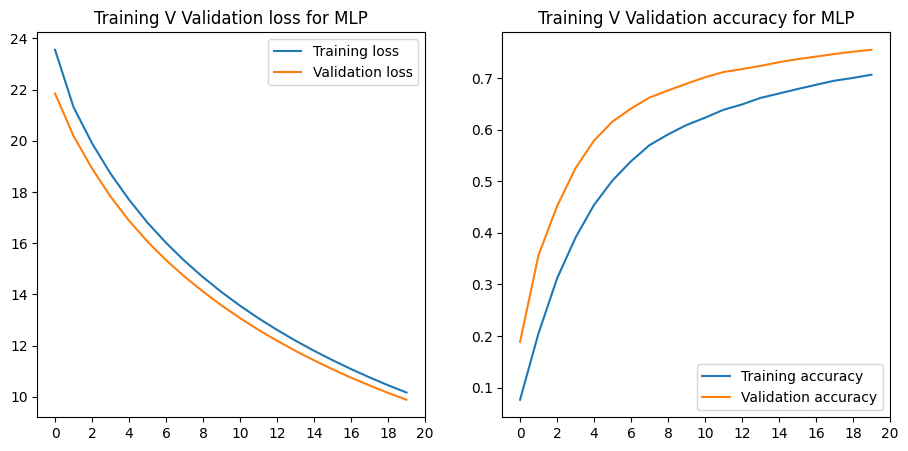

In [62]:
#plotting loss and accuracy graphs for mlp
f_mlp, ax_mlp = plt.subplots(1, 2, figsize=(11,5))

ax_mlp[0].plot(history_mlp.history['loss'], label = 'Training loss')
ax_mlp[0].plot(history_mlp.history['val_loss'], label = 'Validation loss')
ax_mlp[0].set_title("Training V Validation loss for MLP")
ax_mlp[0].set_xticks([*range(0,21,2)])
ax_mlp[0].legend(loc="upper right")

ax_mlp[1].plot(history_mlp.history['accuracy'], label = 'Training accuracy')
ax_mlp[1].plot(history_mlp.history['val_accuracy'], label = 'Validation accuracy')
ax_mlp[1].set_title("Training V Validation accuracy for MLP")
ax_mlp[1].set_xticks([*range(0,21,2)])
ax_mlp[1].legend(loc="lower right")

plt.show()

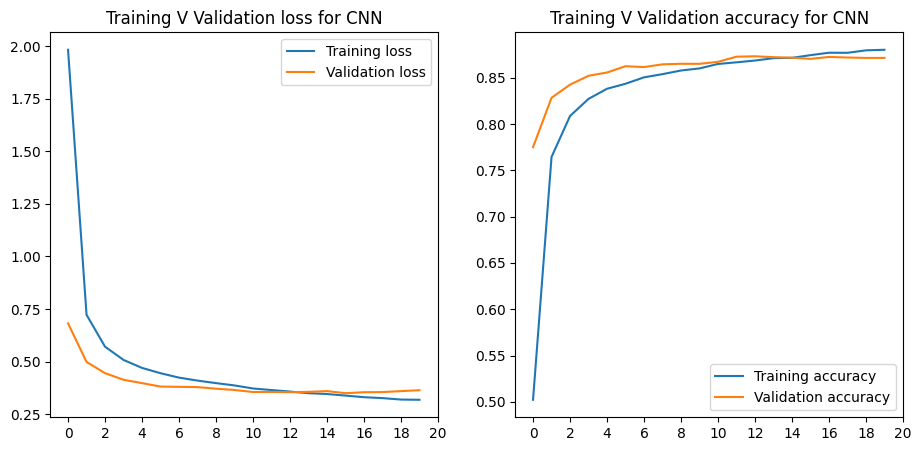

In [63]:
#plotting loss and accuracy graphs for mlp
f_cnn, ax_cnn = plt.subplots(1, 2, figsize=(11,5))

ax_cnn[0].plot(history_cnn.history['loss'], label = 'Training loss')
ax_cnn[0].plot(history_cnn.history['val_loss'], label = 'Validation loss')
ax_cnn[0].set_title("Training V Validation loss for CNN")
ax_cnn[0].set_xticks([*range(0,21,2)])
ax_cnn[0].legend(loc="upper right")

ax_cnn[1].plot(history_cnn.history['accuracy'], label = 'Training accuracy')
ax_cnn[1].plot(history_cnn.history['val_accuracy'], label = 'Validation accuracy')
ax_cnn[1].set_title("Training V Validation accuracy for CNN")
ax_cnn[1].set_xticks([*range(0,21,2)])
ax_cnn[1].legend(loc="lower right")

plt.show()

#Test dataset prediction MLP

In [64]:
#predict labels from test dataset using mlp model
labels_mlp = model_mlp.predict(x_test)

588/588 [==============================] - 1s 2ms/step


In [65]:
#print labels, precision/recall/f1/accuracy score for mlp model
y_pred_mlp = np.argmax(labels_mlp,1)
Y_mlp = np.argmax(y_test,1)

precision_mlp = precision_score(Y_mlp, y_pred_mlp,average='weighted')
recall_mlp = recall_score(Y_mlp, y_pred_mlp,average='weighted')
f1_mlp = f1_score(Y_mlp, y_pred_mlp,average='weighted')
acc_mlp = accuracy_score(Y_mlp,y_pred_mlp)


print('First 6 labels:',Y_mlp[:6])
print('Precision score for mlp:\t',precision_mlp)
print('Recall score for mlp:\t',recall_mlp)
print('F1 score for mlp:\t',f1_mlp)
print('Accuracy score for mlp:\t',acc_mlp)

label_mlp = list(Y_mlp[:6])

First 6 labels: [41 39  9 26 44 33]
Precision score for mlp:	 0.7560105469597053
Recall score for mlp:	 0.7564893617021277
F1 score for mlp:	 0.7531431625908981
Accuracy score for mlp:	 0.7564893617021277


[41, 39, 9, 26, 44, 33]
['g', 'e', '9', 'Q', 'q', 'X']
['g', 'e', '9', 'Q', 'q', 'X']


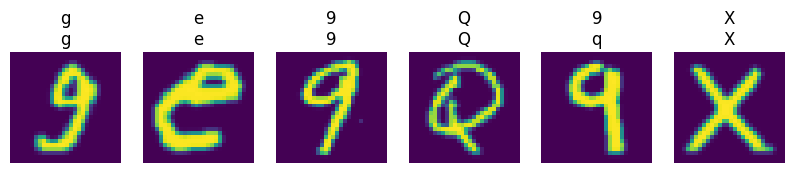

In [66]:
#print first six samples from dataset along with predicted and true values
print(label_mlp)
sns_tick_mlp = [label[x] for x in label_mlp]
pred_mlp = [label[x] for x in list(y_pred_mlp[:6])]

print(pred_mlp)
print(sns_tick_mlp)


fig_mlp = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows_mlp = 1
columns_mlp = 6
  
# Adds a subplot at the 1st position
fig_mlp.add_subplot(rows_mlp, columns_mlp, 1)
  
# showing image
plt.imshow(x_test[0])
plt.axis('off')
plt.title("g\ng")

fig_mlp.add_subplot(rows_mlp, columns_mlp, 2)
  
# showing image
plt.imshow(x_test[1])
plt.axis('off')
plt.title("e\ne")

fig_mlp.add_subplot(rows_mlp, columns_mlp, 3)
  
# showing image
plt.imshow(x_test[2])
plt.axis('off')
plt.title("9\n9")

fig_mlp.add_subplot(rows_mlp, columns_mlp, 4)
  
# showing image
plt.imshow(x_test[3])
plt.axis('off')
plt.title("Q\nQ")

fig_mlp.add_subplot(rows_mlp, columns_mlp, 5)
# showing image
plt.imshow(x_test[4])
plt.axis('off')
plt.title("9\nq")

fig_mlp.add_subplot(rows_mlp, columns_mlp, 6)
# showing image
plt.imshow(x_test[5])
plt.axis('off')
plt.title("X\nX")

plt.show()

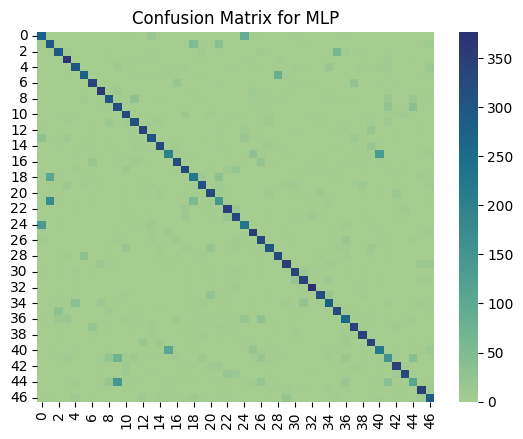

In [67]:
#plot confusion matrix for mlp predictions
con_mlp = confusion_matrix(Y_mlp, y_pred_mlp)
ax1 = plt.axes()
sns.heatmap(con_mlp, ax=ax1, cmap="crest")
ax1.set_title("Confusion Matrix for MLP")
plt.show()


#Test dataset prediction CNN

In [68]:
#predict labels from test dataset using mlp model
labels_cnn = model_cnn.predict(x_test)

588/588 [==============================] - 1s 2ms/step


In [69]:
#print labels, precision/recall/f1/accuracy score for mlp model
y_pred_cnn = np.argmax(labels_cnn,1)
Y_cnn = np.argmax(y_test,1)

precision_cnn = precision_score(Y_cnn, y_pred_cnn,average='weighted')
recall_cnn = recall_score(Y_cnn, y_pred_cnn,average='weighted')
f1_cnn = f1_score(Y_cnn, y_pred_cnn,average='weighted')
acc_cnn = accuracy_score(Y_cnn,y_pred_cnn)

print('First 6 labels:',Y_cnn[:7])
print('Precision score for cnn:\t',precision_cnn)
print('Recall score for cnn:\t',recall_cnn)
print('F1 score for cnn:\t',f1_cnn)
print('Accuracy score for cnn:\t',acc_cnn)

label_cnn = list(Y_cnn[:6])

First 6 labels: [41 39  9 26 44 33 14]
Precision score for cnn:	 0.8762013938055732
Recall score for cnn:	 0.8738829787234043
F1 score for cnn:	 0.8724423850292586
Accuracy score for cnn:	 0.8738829787234043


[41, 39, 9, 26, 44, 33]
['g', 'e', '9', 'Q', '9', 'X']
['g', 'e', '9', 'Q', 'q', 'X']


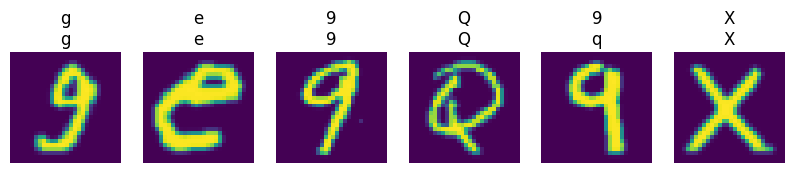

In [70]:
#print first six samples from dataset along with predicted and true values
print(label_cnn)
con_cnn = confusion_matrix(Y_cnn, y_pred_cnn, labels=label_cnn)
sns_tick_cnn = [label[x] for x in label_cnn]
pred_cnn = [label[x] for x in list(y_pred_cnn[:6])]

print(pred_cnn)
print(sns_tick_cnn)


fig_cnn = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows_cnn = 1
columns_cnn = 6
  
# Adds a subplot at the 1st position
fig_cnn.add_subplot(rows_cnn, columns_cnn, 1)
  
# showing image
plt.imshow(x_test[0])
plt.axis('off')
plt.title("g\ng")

fig_cnn.add_subplot(rows_cnn, columns_cnn, 2)
  
# showing image
plt.imshow(x_test[1])
plt.axis('off')
plt.title("e\ne")

fig_cnn.add_subplot(rows_cnn, columns_cnn, 3)
  
# showing image
plt.imshow(x_test[2])
plt.axis('off')
plt.title("9\n9")

fig_cnn.add_subplot(rows_cnn, columns_cnn, 4)
  
# showing image
plt.imshow(x_test[3])
plt.axis('off')
plt.title("Q\nQ")

fig_cnn.add_subplot(rows_cnn, columns_cnn, 5)
# showing image
plt.imshow(x_test[4])
plt.axis('off')
plt.title("9\nq")

fig_cnn.add_subplot(rows_cnn, columns_cnn, 6)
# showing image
plt.imshow(x_test[5])
plt.axis('off')
plt.title("X\nX")

plt.show()

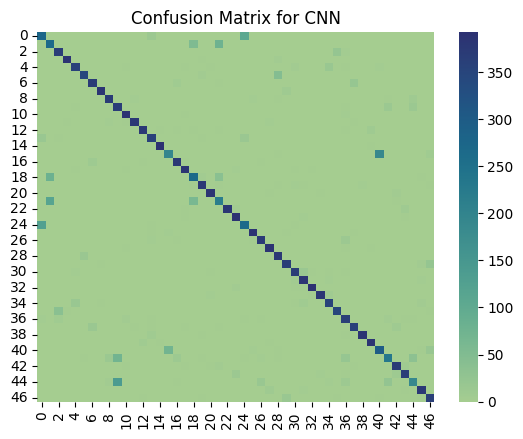

In [71]:
#print confusion matrix for cnn predictions
con_cnn = confusion_matrix(Y_cnn, y_pred_cnn)
ax2 = plt.axes()
sns.heatmap(con_cnn, ax=ax2, cmap='crest')
ax2.set_title("Confusion Matrix for CNN")
plt.show()

#Comparing performance

In [74]:
#compare performance of both models using precision/recall/f1/accuracy scores
table = [[precision_mlp, recall_mlp, f1_mlp, acc_mlp],[precision_cnn, recall_cnn, f1_cnn, acc_cnn]]

df = pd.DataFrame(table, columns = ["Precision","Recall","F1","Accuracy"], index = ["MLP","CNN"])
df

,Precision,Recall,F1,Accuracy
MLP,0.756011,0.756489,0.753143,0.756489
CNN,0.876201,0.873883,0.872442,0.873883
